# Benchmarking Gradient Based Optimisers

To prepare ourselves to perform VQE on bigger molecules and ansatz with many variational parameters, it is important to find a good classical optimisers to ensure fast convergence to the optimal solution. We shall reuse Hydrogen Molecule benchmark the basic gradient descent optimiser against several other PennyLane-provided Gradient-Based optimisers for VQE:

- GradientDescentOptimizer
- AdagradOptimizer
- AdamOptimizer
- MomentumOptimizer
- NesterovMomentumOptimizer
- QNGOptimizer
- RMSPropOptimizer

As seen from previous notebook, the hydrogen molecule VQE posed no challenge to Qamuy. Yet, it is wise to prepare ourselves for larger molecule by doing a simple benchmarking exercise. Therefore, we shall perform a bigger molecule, Tetra-Hydrogen $H_4$ Molecule VQE that uses 8 qubits, to benchmark the following optimisers available in [QAMUY](https://qamuy.qunasys.com/docs/en/):

- BFGS
- BFGS_FTOL
- L_BFGS_B
- POWELL
- CG
- TNC
- SLSQP
- ADAM

### Setting Up VQE in PennyLane

In [20]:
# Native Lib
import itertools as it
import copy

# External Lib
import pennylane as qml
import numpy as np
from pennylane import numpy as plnp
import matplotlib.pyplot as plt

# qanything Lib
import qanything.get_index as getind
import qanything.get_molecule as getmol
import qanything.get_json as getjson

In [2]:
# Create the Hydrogen Molecule
mol_name = 'h2'
mol_full_name = 'hydrogen molecule'
bond_length = 1.4
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length)

# Get the Molecular Hamiltonian (Using Jordan-Wigner)
mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

# Get the Orbital and Single and Double Excitation Index 
occupied_index, single_index, double_index = getind.generate_excite_index(num_qubits, num_elec)

# Get the Disentangled Unitary Coupled Cluster Single Doubles (UCCSD) Excitation Sequence 
disentangle_order = getind.generate_disentanglement_order(occupied_index, single_index, double_index)

# Get the Hartree-Fock State
hf = qml.qchem.hf_state(electrons=num_elec, orbitals=num_qubits)

# Prepare the problem-inspired ansatz based on the Disentangled Sequence
def uccsd_ansatz(params, wires, excitations):
    qml.BasisState(hf, wires=wires)
    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)

# Prepare a device, cost function and optimiser
dev = qml.device("default.qubit", wires=num_qubits)  # Statevector Device
cost_fn = qml.ExpvalCost(uccsd_ansatz, mol_ham, dev, optimize=True)  # Cost Function
max_steps = 100

/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


### Benchmarking PennyLane Optimisers

### Gradient Descent Optimiser

In [3]:
# Basic Gradient Descent
optimiser_gd = qml.GradientDescentOptimizer()  

# Set Initial Parameters and Calculate Initial Energy and Gradient
params = plnp.zeros(len(disentangle_order), requires_grad=True)
grads = qml.grad(cost_fn)(params, excitations=disentangle_order)
gd_params_hist = plnp.zeros((max_steps,len(params)))
gd_params_hist[0] = params
gd_energy_hist = np.zeros(max_steps)

# Perform VQE
for step in range(max_steps):
    params, energy = optimiser_gd.step_and_cost(cost_fn, params, excitations=disentangle_order)
    gd_energy_hist[step] = energy
    gd_params_hist[step] = params
    if (step+1)%10 == 0:
        print(f"Iter: {step+1}, Energy: {energy}")
    elif step == 0:
        print(f"Iter: {step+1}, Energy: {energy}")

Iter: 1, Energy: -1.116714325063832
Iter: 10, Energy: -1.1194808918547907
Iter: 20, Energy: -1.1221246714906385
Iter: 30, Energy: -1.1243788599312177
Iter: 40, Energy: -1.126299987480848
Iter: 50, Energy: -1.1279366253161764
Iter: 60, Energy: -1.1293304382341816
Iter: 70, Energy: -1.1305171174252007
Iter: 80, Energy: -1.1315272011993793
Iter: 90, Energy: -1.132386793026507
Iter: 100, Energy: -1.1331181868036744


### Adagrad Optimiser

In [4]:
# Repeat VQE using Adagrad
optimiser_ag = qml.AdagradOptimizer()

# Set Initial Parameters and Calculate Initial Energy and Gradient
params = plnp.zeros(len(disentangle_order), requires_grad=True)
grads = qml.grad(cost_fn)(params, excitations=disentangle_order)
ag_params_hist = plnp.zeros((max_steps,len(params)))
ag_params_hist[0] = params
ag_energy_hist = np.zeros(max_steps)

# Perform VQE
for step in range(max_steps):
    params, energy = optimiser_ag.step_and_cost(cost_fn, params, excitations=disentangle_order)
    ag_energy_hist[step] = energy
    ag_params_hist[step] = params
    if (step+1)%10 == 0:
        print(f"Iter: {step+1}, Energy: {energy}")
    elif step == 0:
        print(f"Iter: {step+1}, Energy: {energy}")

Iter: 1, Energy: -1.116714325063832
Iter: 10, Energy: -1.1240814264400965
Iter: 20, Energy: -1.1272936175675705
Iter: 30, Energy: -1.1293321153061757
Iter: 40, Energy: -1.1307960775592905
Iter: 50, Energy: -1.1319101234871383
Iter: 60, Energy: -1.1327871653468837
Iter: 70, Energy: -1.1334931823706553
Iter: 80, Energy: -1.1340705023046953
Iter: 90, Energy: -1.1345480678039879
Iter: 100, Energy: -1.1349466053058281


### Adam Optimiser

In [5]:
# Repeat VQE using Adam
optimiser_ad = qml.AdamOptimizer()

# Set Initial Parameters and Calculate Initial Energy and Gradient
params = plnp.zeros(len(disentangle_order), requires_grad=True)
grads = qml.grad(cost_fn)(params, excitations=disentangle_order)
ad_params_hist = plnp.zeros((max_steps,len(params)))
ad_params_hist[0] = params
ad_energy_hist = np.zeros(max_steps)

# Perform VQE
for step in range(max_steps):
    params, energy = optimiser_ad.step_and_cost(cost_fn, params, excitations=disentangle_order)
    ad_energy_hist[step] = energy
    ad_params_hist[step] = params
    if (step+1)%10 == 0:
        print(f"Iter: {step+1}, Energy: {energy}")
    elif step == 0:
        print(f"Iter: {step+1}, Energy: {energy}")

Iter: 1, Energy: -1.116714325063832
Iter: 10, Energy: -1.1296615512684802
Iter: 20, Energy: -1.1362438780372983
Iter: 30, Energy: -1.1372542010463873
Iter: 40, Energy: -1.137010764046784
Iter: 50, Energy: -1.137173729309327
Iter: 60, Energy: -1.137275762381213
Iter: 70, Energy: -1.1372628704162342
Iter: 80, Energy: -1.1372721696831931
Iter: 90, Energy: -1.1372756751882864
Iter: 100, Energy: -1.137275136523455


### Momentum Optimiser

In [6]:
# Repeat VQE using Momentum
optimiser_mo = qml.MomentumOptimizer()

# Set Initial Parameters and Calculate Initial Energy and Gradient
params = plnp.zeros(len(disentangle_order), requires_grad=True)
grads = qml.grad(cost_fn)(params, excitations=disentangle_order)
mo_params_hist = plnp.zeros((max_steps,len(params)))
mo_params_hist[0] = params
mo_energy_hist = np.zeros(max_steps)

# Perform VQE
for step in range(max_steps):
    params, energy = optimiser_mo.step_and_cost(cost_fn, params, excitations=disentangle_order)
    mo_energy_hist[step] = energy
    mo_params_hist[step] = params
    if (step+1)%10 == 0:
        print(f"Iter: {step+1}, Energy: {energy}")
    elif step == 0:
        print(f"Iter: {step+1}, Energy: {energy}")

Iter: 1, Energy: -1.116714325063832
Iter: 10, Energy: -1.1261231271495138
Iter: 20, Energy: -1.1356168383420238
Iter: 30, Energy: -1.137272234121366
Iter: 40, Energy: -1.1370245637503873
Iter: 50, Energy: -1.1371090753032842
Iter: 60, Energy: -1.1372452153728452
Iter: 70, Energy: -1.1372758827371876
Iter: 80, Energy: -1.137272980507658
Iter: 90, Energy: -1.137273505858157
Iter: 100, Energy: -1.137275399066614


### Nesterov Momentum

In [7]:
# Repeat VQE using Nesterov Momentum
optimiser_ne = qml.NesterovMomentumOptimizer()

# Set Initial Parameters and Calculate Initial Energy and Gradient
params = plnp.zeros(len(disentangle_order), requires_grad=True)
grads = qml.grad(cost_fn)(params, excitations=disentangle_order)
ne_params_hist = plnp.zeros((max_steps,len(params)))
ne_params_hist[0] = params
ne_energy_hist = np.zeros(max_steps)

# Perform VQE
for step in range(max_steps):
    params, energy = optimiser_ne.step_and_cost(cost_fn, params, excitations=disentangle_order)
    ne_energy_hist[step] = energy
    ne_params_hist[step] = params
    if (step+1)%10 == 0:
        print(f"Iter: {step+1}, Energy: {energy}")
    elif step == 0:
        print(f"Iter: {step+1}, Energy: {energy}")

Iter: 1, Energy: -1.116714325063832
Iter: 10, Energy: -1.1271284608351326
Iter: 20, Energy: -1.1357772964199706
Iter: 30, Energy: -1.1372758660334001
Iter: 40, Energy: -1.137126824761023
Iter: 50, Energy: -1.1371678327390613
Iter: 60, Energy: -1.1372524083363311
Iter: 70, Energy: -1.1372753773551971
Iter: 80, Energy: -1.1372750891808825
Iter: 90, Energy: -1.1372748988024832
Iter: 100, Energy: -1.1372756236450963


### QNG Optimiser

In [8]:
# Repeat VQE using QNGOptimizer
optimiser_qn = qml.QNGOptimizer()

# Set Initial Parameters and Calculate Initial Energy and Gradient
params = plnp.zeros(len(disentangle_order), requires_grad=True)
grads = qml.grad(cost_fn)(params, excitations=disentangle_order)
qn_params_hist = plnp.zeros((max_steps,len(params)))
qn_params_hist[0] = params
qn_energy_hist = np.zeros(max_steps)

# Perform VQE
for step in range(max_steps):
    params, energy = optimiser_qn.step_and_cost(cost_fn, params, excitations=disentangle_order)
    qn_energy_hist[step] = energy
    qn_params_hist[step] = params
    if (step+1)%10 == 0:
        print(f"Iter: {step+1}, Energy: {energy}")
    elif step == 0:
        print(f"Iter: {step+1}, Energy: {energy}")

Iter: 1, Energy: -1.116714325063832
Iter: 10, Energy: -1.1258367718101239
Iter: 20, Energy: -1.1313312601081291
Iter: 30, Energy: -1.1341918587449222
Iter: 40, Energy: -1.1356773397310758
Iter: 50, Energy: -1.136447702821736
Iter: 60, Energy: -1.136846931743156
Iter: 70, Energy: -1.137053751520683
Iter: 80, Energy: -1.1371608741136627
Iter: 90, Energy: -1.137216353046455
Iter: 100, Energy: -1.1372450842205444


### RMSProp Optimiser

In [9]:
# Repeat VQE using RMSPropOptimizer
optimiser_rm = qml.RMSPropOptimizer()

# Set Initial Parameters and Calculate Initial Energy and Gradient
params = plnp.zeros(len(disentangle_order), requires_grad=True)
grads = qml.grad(cost_fn)(params, excitations=disentangle_order)
rm_params_hist = plnp.zeros((max_steps,len(params)))
rm_params_hist[0] = params
rm_energy_hist = np.zeros(max_steps)

# Perform VQE
for step in range(max_steps):
    params, energy = optimiser_rm.step_and_cost(cost_fn, params, excitations=disentangle_order)
    rm_energy_hist[step] = energy
    rm_params_hist[step] = params
    if (step+1)%10 == 0:
        print(f"Iter: {step+1}, Energy: {energy}")
    elif step == 0:
        print(f"Iter: {step+1}, Energy: {energy}")

Iter: 1, Energy: -1.116714325063832
Iter: 10, Energy: -1.1340433056754216
Iter: 20, Energy: -1.1369267753595036
Iter: 30, Energy: -1.1372626331903968
Iter: 40, Energy: -1.1372748473649217
Iter: 50, Energy: -1.1372655413942243
Iter: 60, Energy: -1.1372642284218457
Iter: 70, Energy: -1.137269598421244
Iter: 80, Energy: -1.1372684291426467
Iter: 90, Energy: -1.137266659559804
Iter: 100, Energy: -1.137266762936945


### Results

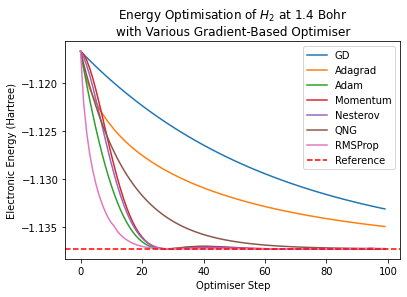

In [15]:
fig, ax = plt.subplots()

limit_step = 100
ax.plot(np.arange(0,max_steps)[:limit_step],gd_energy_hist[:limit_step], label='GD')
ax.plot(np.arange(0,max_steps)[:limit_step],ag_energy_hist[:limit_step], label='Adagrad')
ax.plot(np.arange(0,max_steps)[:limit_step],ad_energy_hist[:limit_step], label='Adam')
ax.plot(np.arange(0,max_steps)[:limit_step],mo_energy_hist[:limit_step], label='Momentum')
ax.plot(np.arange(0,max_steps)[:limit_step],ne_energy_hist[:limit_step], label='Nesterov')
ax.plot(np.arange(0,max_steps)[:limit_step],qn_energy_hist[:limit_step], label='QNG')
ax.plot(np.arange(0,max_steps)[:limit_step],rm_energy_hist[:limit_step], label='RMSProp')
ax.axhline(y=-1.1372759436170639, color='r', linestyle='--', label="Reference")
ax.set_xlabel('Optimiser Step')
ax.set_ylabel('Electronic Energy (Hartree)')
ax.set_title(r'Energy Optimisation of $H_2$ at 1.4 Bohr'+ f'\nwith Various Gradient-Based Optimiser')
ax.legend()
fig.savefig('h2_benchmark_penny_opt.png', format='png')

### Discussion
The graph above shows that RMSProp & Adam Optimisers are among the fastest optimiser while the Adagrad & basic gradient descent optimisers are among the slowest. Based on the current results, we decided to rank the optimisers based on the convergene rate and the convergence accuracy as follows:

Optimiser Ranking:
1. RMSProp
2. Adam
3. Nesterov
4. Momentum
5. QNG
6. Adagrad
7. Gradient Descent

NOTE: THIS RANKING IS NOT A REPRESENTATIVE OF THE ACTUAL PERFORMANCE OF THESE OPTIMISERS. THIS RANKING IS FOR JUST THIS DEMONSTRATION ONLY.

In [11]:
# # Saving Data
# filename = 'vqe_hydrogen_numerical.json'
# save_data = {}
# save_data['header_names'] = ['meta','gd_energy_hist', 
# 'ag_energy_hist', 
# 'ad_energy_hist', 
# 'mo_energy_hist', 
# 'ne_energy_hist', 
# 'qn_energy_hist',
# 'rm_energy_hist', 
# 'gd_params_hist', 
# 'ag_params_hist', 
# 'ad_params_hist', 
# 'mo_params_hist', 
# 'ne_params_hist', 
# 'qn_params_hist',
# 'rm_params_hist',]
# save_data['meta'] = {'gd': "Gradient Descent",
# 'ag': "Adagrad",
# 'ad': "Adam",
# 'mo': "Momentum",
# 'ne': "Nesterov",
# 'qn': "QNG",
# 'rm': "RMSProp",
# 'stepsize' : 0.01}
# save_data['gd_energy_hist'] = gd_energy_hist
# save_data['ag_energy_hist'] = ag_energy_hist
# save_data['ad_energy_hist'] = ad_energy_hist
# save_data['mo_energy_hist'] = mo_energy_hist
# save_data['ne_energy_hist'] = ne_energy_hist
# save_data['qn_energy_hist'] = qn_energy_hist
# save_data['rm_energy_hist'] = rm_energy_hist

# save_data['gd_params_hist'] = gd_params_hist
# save_data['ag_params_hist'] = ag_params_hist
# save_data['ad_params_hist'] = ad_params_hist
# save_data['mo_params_hist'] = mo_params_hist
# save_data['ne_params_hist'] = ne_params_hist
# save_data['qn_params_hist'] = qn_params_hist
# save_data['rm_params_hist'] = rm_params_hist

# getjson.save_to_json(filename,save_data)

### Setting VQE in Qamuy

In [16]:
import qamuy.chemistry as qy
from qamuy.client import Client

In [102]:
# Create Hydrogen Molecule
mol_name = 'tetra_h4'
mol_full_name = 'tetra hydrogen molecule'
bond_length = 0.529177249 * 1.4 # Convert to Angstroms

# Get Hydrogen Molecule
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length)
new_coords = coords.reshape((4,3)).tolist()
setting = qy.QamuyChemistryInput()
molecule = setting.target_molecule
molecule.geometry = qy.molecule_geometry(mol_symbols, new_coords)
molecule.basis = "sto-3g"
molecule.multiplicity = 1
molecule.num_excited_states = 0

# Set Fermion to Spin Mapping
setting.mapping.type = "JORDAN_WIGNER"

# Set Quantum Algorithm 
setting.solver.type = "VQE"

# Set cost function
setting.cost_function.type = "NONE"

# Set ansatz
setting.ansatz.type = "UCCSD"
setting.ansatz.trotter_steps = 1
setting.ansatz.reference_state = 'RHF'
setting.ansatz.initial_parameter = [0]
setting.ansatz.use_random_initial_guess = False

# Quantum Device
setting.quantum_device.type = "EXACT_SIMULATOR"

# Ab Inito Calculation For Reference
setting.post_hf_methods.append(qy.PostHFMethod(type="FCI"))

### Benchmarking QAMUY Optimisers

In [103]:
# My Optimiser
my_optimiser_list = ['BFGS','BFGS_FTOL','L_BFGS_B', 'POWELL', 'CG', 'TNC', 'SLSQP', 'ADAM' ]

# Prepare Inputs for Jobs Submission
jobs = []
for my_opt in my_optimiser_list:
    new_input = copy.deepcopy(setting)
    new_input.optimizer.type = my_opt
    new_input.optimizer.max_iter = 100
    new_input.optimizer.max_fev = 500
    jobs.append(client.submit(new_input))

# Submit Jobs for computation
results = client.wait_and_get_job_results(jobs)
outputs = [res.output for res in results]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   42.4s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   52.7s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  1.6min remaining:   56.4s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.8min finished


In [114]:
# Collect VQE Optimisation Results
hf_energy_qamuy = np.zeros(len(my_optimiser_list))
ref_energy_qamuy = np.zeros(len(my_optimiser_list))
vqe_energy_qamuy = np.zeros(len(my_optimiser_list))
vqe_opt_message_qamuy = []
qy_energy_hist_uccsd_list = []
opt_steps_list  = []
for i in range(len(my_optimiser_list)):
    hf_energy = outputs[i].molecule_result.hf_result.evaluated_properties[0].energy.values[0].value
    hf_energy_qamuy[i] = hf_energy
    ref_energy = outputs[i].molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[0].value
    ref_energy_qamuy[i] = ref_energy
    opt_message = outputs[0].molecule_result.quantum_device_result.vqe_log.message
    vqe_opt_message_qamuy.append(opt_message)
    qy_energy_hist_uccsd_ = outputs[i].molecule_result.quantum_device_result.vqe_log.cost_hist[0].history
    vqe_energy_qamuy[i] = qy_energy_hist_uccsd_[-1]
    qy_energy_hist_uccsd = [hf_energy] + list(qy_energy_hist_uccsd_)
    qy_energy_hist_uccsd_list.append(qy_energy_hist_uccsd)
    opt_steps_list.append(outputs[i].molecule_result.quantum_device_result.vqe_log.nit + 1)


### Results

In [116]:
# Show Results
print(f'Quantum Resource:\n{outputs[0].molecule_result.quantum_device_result.vqe_log.quantum_resources.circuit}\n')
for i in range(len(my_optimiser_list)):
    print(f'Optimiser: {my_optimiser_list[i]}')
    print(f'Iter: {opt_steps_list[i]}')
    print(f'Hartree-Fock Energy: {hf_energy_qamuy[i]}')
    print(f'Reference Energy: {ref_energy_qamuy[i]}')
    print(f'Final Energy: {vqe_energy_qamuy[i]}')
    
    print(f'Message: {vqe_opt_message_qamuy[i]}\n')

Quantum Resource:
{'num_qubit': 8, 'num_parameter': 26, 'num_gate': 1472, 'num_1qubit_gate': 160, 'num_2qubit_gate': 1312}

Optimiser: BFGS
Iter: 47
Hartree-Fock Energy: -1.409119239809351
Reference Energy: -1.8508936397612863
Final Energy: -1.85089362521754
Message: Optimization terminated successfully.

Optimiser: BFGS_FTOL
Iter: 27
Hartree-Fock Energy: -1.409119239809351
Reference Energy: -1.850893639761288
Final Energy: -1.8508822376235794
Message: Optimization terminated successfully.

Optimiser: L_BFGS_B
Iter: 22
Hartree-Fock Energy: -1.409119239809351
Reference Energy: -1.850893639761288
Final Energy: -1.8508716300389942
Message: Optimization terminated successfully.

Optimiser: POWELL
Iter: 3
Hartree-Fock Energy: -1.4091192398093528
Reference Energy: -1.8508936397612876
Final Energy: -1.8415048162096315
Message: Optimization terminated successfully.

Optimiser: CG
Iter: 101
Hartree-Fock Energy: -1.4091192398093528
Reference Energy: -1.850893639761289
Final Energy: -1.8508936170

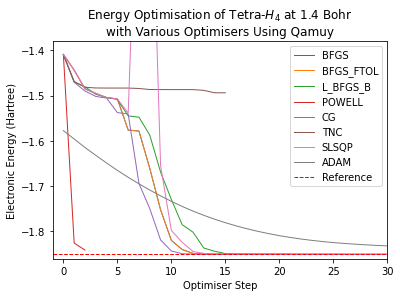

In [118]:
# Plot the results
fig2, ax2 = plt.subplots()
for i in range(len(my_optimiser_list)):
    ax2.plot(np.arange(0,opt_steps_list[i]),qy_energy_hist_uccsd_list[i], label=my_optimiser_list[i], lw=1)
ax2.axhline(y=ref_energy, color='r', linestyle='--', label="Reference", lw=1)
ax2.set_xlabel('Optimiser Step')
ax2.set_ylabel('Electronic Energy (Hartree)')
ax2.set_title(r'Energy Optimisation of Tetra-$H_4$ at 1.4 Bohr'+ f'\nwith Various Optimisers Using Qamuy')
ax2.set_ylim([sum(ref_energy_qamuy)/len(ref_energy_qamuy)-0.01,sum(hf_energy_qamuy)/len(hf_energy_qamuy)+0.05])
ax2.set_xlim([-1,30])
ax2.legend()

### Discussion

The graph above shows that Powell has the fastest convergence but it prematurely stops before converging to the reference ground energy. BFGS, BFGS_FTOL, L-BFGS-B and CG were among the fastest that converge to the reference, with BFGS having the most accurate final solution. SLSQP has a strange increase in the electronic energy, which might indicate instability in the optimiser algorithm. TNC fails to converge while Adam converges slowly to the reference. It is noted that Adam starts with the wrong Hartree-Fock Energy, which may be a symptom of an unresolved bug.

Based on this result, we shall continue the use of BFGS optimiser as it provides reasonably fast convergence rate and accurate final solution.